In [ ]:
!nvidia-smi

Thu Jun  2 04:33:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
import torchvision.models as models
vgg16 = models.vgg16(pretrained=True)
print(vgg16)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
import torch #torch 자체
import torch.nn as nn  #torch에서 network 성분 가져올때
import torch.nn.functional as F 
from torchsummary import summary #network 분석 시 사용하는 package 많이 사용하진 않음

import torch.optim as optim
from torch.utils.data import DataLoader,random_split
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms  # dataset은 데이터셋 저장, transforms는 data augmentation기법에 사용
from torchvision import utils

import numpy as np
import matplotlib.pyplot as plt

 ### Step 1) 데이터 불러오기 및 전처리 

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(), 
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
     )

In [ ]:
train_dataset = datasets.CIFAR10(root="../data", train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root="../data", train=False, download=True, transform=transform)
split = 0.2
val=int(len(train_dataset)*split)
train = int(len(train_dataset)*(1-split))
train, valid = random_split(train_dataset,[train,val])
print(len(train),len(valid))

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified
40000 10000


In [ ]:
writer = SummaryWriter()
train_loader = DataLoader(train,batch_size=64,num_workers=2)
valid_loader = DataLoader(valid,batch_size=64,num_workers=2) 
test_loader = DataLoader(test_dataset, batch_size=64)

image, label = next(iter(train_loader))
grid = utils.make_grid(image)
writer.add_image('images', grid, 0)

In [ ]:
def imshow(img):
  img = (img/2 + 0.5)
  np_img = img.numpy()
  plt.imshow(np.transpose(np_img,(1,2,0)))

In [ ]:
for i,data in  enumerate(train_loader):
  img,labels = data
  print(img.shape,labels.shape)
  break

torch.Size([64, 3, 32, 32]) torch.Size([64])


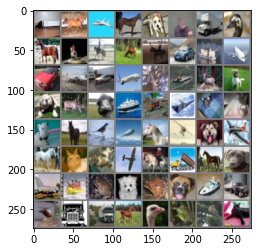

In [ ]:
imshow(grid)

### Step 2) 네트워크 생성

- input_dim: 입력 데이터의 차원

- hidden_dim_list: 은닉 계층의 뉴런 수

- output_dim: 결과 데이터의 차원

In [ ]:
#nn의 module을 상속받아서 그 위에 layer를 쌓아올림
#linear안에는 input, output sizef를 입력할 수 있습니다.
class MyModel(nn.Module):  #네트워크 구성 성분 입력
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=32,kernel_size=5,padding='same')
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=5,padding='same')
        self.batchnorm2 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,padding='same')
        self.batchnorm3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,padding='same')
        self.batchnorm4 = nn.BatchNorm2d(256)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.conv5 = nn.Conv2d(in_channels=256,out_channels=512,kernel_size=3,padding='same')
        self.batchnorm5 = nn.BatchNorm2d(512)
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(8192,2048)
        self.batchnorm7 = nn.BatchNorm1d(2048)
        self.fc2 = nn.Linear(2048,256)
        self.batchnorm8 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256,10)

    def forward(self,x):
      x = F.relu(self.conv1(x))
      x = F.relu(self.conv2(x))
      x = self.pool1(x)
      x = F.relu(self.conv3(x))
      x = F.relu(self.conv4(x))
      x = self.pool2(x)
      x = F.relu(self.conv5(x))
      x = self.pool3(x)
      x = self.flatten(x)
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = self.fc3(x)
      return x




In [ ]:
model = vgg16

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
vgg16.classifier = nn.Linear(25088,10)

In [ ]:
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
summary(model,input_size=(3,32,32))
#summary(model2,input_size=(3072,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          36,928
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
              ReLU-9          [-1, 128, 16, 16]               0
        MaxPool2d-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         295,168
             ReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]         590,080
             ReLU-14            [-1, 25

### Step 3) 손실 함수 (Loss) 및 업데이트 알고리즘 (Optimizer) 설정


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=model.parameters(), lr=0.0005)

### Step 4) 학습 (Training)

 - CIFAR-10 데이터셋을 이용하여 다층퍼셉트론을 학습시켜봅시다.

 - 학습 과정은 다음과 같습니다.

    1. 입력 (x)에 대한 결과 **예측** -> y_pred

    2. y_pred와 정답 (y_true)을 비교하여 **손실함수의 값 계산** -> criterion(y_pred, y_true)

    3. 손실함수의 값이 작아지는 방향으로 네트워크 **업데이트** -> optimizer.step()

In [ ]:
epochs = 15

for epoch in range(epochs):  
    running_loss = 0
    train_loss = 0

    for i, data in enumerate(train_loader):
        # Batch에 해당하는 Data 추출
        x, y_true = data #x는 input data에 해당 y_true는 label에
        #x = x.reshape(-1, 32*32*3) #flatten
        x = x.to(device) 
        y_true = y_true.to(device) 

        optimizer.zero_grad()
        
        # 입력에 대한 결과 예측
        y_pred = model(x)

        # 예측값과 정답을 비교하여 손실함수의 값 계산
        loss = criterion(y_pred, y_true)
        # 손실함수의 값이 작아지는 방향으로 네트워크 업데이트
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        running_loss += loss.item() #로깅용 running_loss
    train_loss /= len(train_loader)


    correct = 0
    total = 0
    val_loss = 0
    with torch.no_grad():
        for i, data in enumerate(valid_loader):
        #for i, (images,labels) in enumerate(valid_loader):
            images,labels=data
            #images = images.reshape(-1, 32*32*3)
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs,labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            val_acc = 100 * correct / total
            writer.add_scalar("Acc/valid", val_acc, epoch)

    val_loss = val_loss / len(valid_loader)
    writer.add_scalars("Loss",{'train_loss':train_loss,'valid_loss':val_loss},epoch)
    print('Epoch {}, Train Loss: {}, Val Loss: {}, Val Acc: {}'.format(epoch, train_loss, val_loss, val_acc ))





Epoch 0, Train Loss: 1.6252378067016602, Val Loss: 1.2804840598136755, Val Acc: 53.93
Epoch 1, Train Loss: 1.0941689378738404, Val Loss: 0.9480596849113513, Val Acc: 66.48
Epoch 2, Train Loss: 0.8216871172904968, Val Loss: 0.8141309429126181, Val Acc: 71.06
Epoch 3, Train Loss: 0.6488043946743012, Val Loss: 0.8363798737146293, Val Acc: 71.69
Epoch 4, Train Loss: 0.5087800667762756, Val Loss: 0.83438164261496, Val Acc: 73.04
Epoch 5, Train Loss: 0.3885755395889282, Val Loss: 0.8696888258123094, Val Acc: 73.47
Epoch 6, Train Loss: 0.29307292267084123, Val Loss: 1.1309461244352303, Val Acc: 71.92
Epoch 7, Train Loss: 0.21820813829898833, Val Loss: 1.1101404066867888, Val Acc: 73.91
Epoch 8, Train Loss: 0.1671201224207878, Val Loss: 1.1488383046001385, Val Acc: 74.53
Epoch 9, Train Loss: 0.12808201898485422, Val Loss: 1.2612278677855329, Val Acc: 74.36
Epoch 10, Train Loss: 0.09254260847344994, Val Loss: 1.2920769139365027, Val Acc: 75.6
Epoch 11, Train Loss: 0.08097788138911129, Val Loss:

### Step 5) 성능평가 (Evaluation)

In [ ]:
def evaluation(model):
  model.eval()
  correct = 0
  total = 0
  with torch.no_grad():
        for data in test_loader:
            images, labels = data
            #images = images.reshape(-1, 3072)
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_acc = 100 * correct / total
            
  return test_acc

In [ ]:
print(evaluation(model))

75.92


In [ ]:
%load_ext tensorboard
%tensorboard --logdir=runs

In [ ]:
!kill 294

/bin/bash: line 0: kill: (294) - No such process
